# Comparing linear regression and DFL-IO

Steps comparing the linear and inverse-DFL models:
1. Save two datasets
4. Split each dataset into train and test sets
5. Run DFL-IO with each training set, get weights $\theta^{\text{IO,close}}$ and $\theta^{\text{IO,wide}}$
6. Run linear regression on training set, get weights $\theta^{\text{R,close}}$ and $\theta^{\text{R,wide}}$
7. Compare all models on each training set, for each model:
    1. Predict demand using weights and features
    2. Solve MCFND with demand, get design variables $\hat{y}$
    3. Solve MCF-Flow with fixed design variables $\hat{y}$, get $\hat{x}$
    4. Compare costs of $\hat{y}, \hat{x}$ with optimal $x^*, y^*$ 

## Imports and configurations

In [1]:
using JuMP, Gurobi
using LinearAlgebra
using Distributions, Random, PDMats
using MLJ, Tables
using DataFrames, DataFramesMeta
using JLD, CSV
using PlotlyJS
using Pipe
using LaTeXStrings

Random.seed!(42)

TaskLocalRNG()

In [2]:
using Revise

includet("../models/forward.jl")
import .Forward as Forward

includet("../models/inversedemand.jl")
import .InverseDemand as IODemand

includet("../models/inverselinreg.jl")
import .InverseLinReg as IOLinReg

includet("../datagen/data-generation.jl")
import .DataGeneration as DataGen

In [3]:
Linear = @MLJ.load LinearRegressor pkg = "MLJLinearModels"
LAD = @MLJ.load LADRegressor pkg = "MLJLinearModels"

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/luca/.julia/packages/MLJModels/Ft0z9/src/loading.jl:159


import MLJLinearModels ✔


import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/luca/.julia/packages/MLJModels/Ft0z9/src/loading.jl:159


MLJLinearModels.LADRegressor

In [4]:
BASE_DATA_PATH = "../data/"
BASE_RESULTS_PATH = "../results/"

CLOSE_DATA_NAME = "close"
WIDE_DATA_NAME = "wide"

function dataset_path(n_points)
    return joinpath(BASE_DATA_PATH, "data_$n_points.jld") 
end

function results_path(n_points)
    return joinpath(BASE_RESULTS_PATH, "results_$n_points.csv")
end

results_path (generic function with 1 method)

## Problem parameters

Make a smaller problem with 1 commodity and 2 possible arcs, one low-ish capacity ($C$) and one high ($\infty$)


In [35]:
forward_params = Forward.Params(
    n_paths=2, 
    n_commodities=1,
    capacities=[100, 100000],
    design_costs=[10, 100],
    flow_costs=[10 100]',
    enabled_flows=ones(Bool, (2, 1))
)

datagen_params = DataGen.DataGenParams(
    weights=[1.5 -3 2], 
    noise_variance=[5.0^2]
)

inverse_params = IOLinReg.Params(
    n_features=datagen_params.n_features, 
    forward_params=forward_params, 
    with_noise=true,
    norm=IOLinReg.L1
)

Main.InverseLinReg.Params(3, 1, Main.Forward.Params(2, 1, Number[100, 100000], [10, 100], [10; 100;;], Bool[1; 1;;]), true, Main.InverseLinReg.L1)

## Data generation

Generate two datasets using fixed weights $\Theta$:
- $\mathcal{D}_{\text{close}}$ with $\mathbb{E}[d] = C$ 
- $\mathcal{D}_{\text{wide}}$ with $\mathbb{E}[d] \ll C$. 

Procedure for each data point in the dataset:
1. Draw $\phi_1, \ldots, \phi_{m-1} \sim U(a, b)$ for some $a, b$
2. Set $\phi_m$ such that $\sum_{i=1}^m \theta_i \phi_i = \mathbb{E}[d]$
3. Draw noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$ and compute $d = \sum_{i=1}^m \theta_i \phi_i + \epsilon$
4. Solve MCFND for $d$ 
5. Datapoint $(\phi, d, x^*, y^*) \in \mathcal{D}$

Repeat dataset creation for several number of points


In [36]:
n_points = [100, 1000, 3000, 10000]
close_target_demand = 100
wide_target_demand = 20

gurobi_env = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-23


Gurobi.Env(Ptr{Nothing} @0x000000001d5d8830, false, 0)

In [37]:
regenerate = false

if regenerate
    for n in n_points
        close_dataset = DataGen.generate_dataset(forward_params, datagen_params, n_points=n, target_demand=close_target_demand, gurobi_env=gurobi_env)
        wide_dataset = DataGen.generate_dataset(forward_params, datagen_params, n_points=n, target_demand=wide_target_demand, gurobi_env=gurobi_env)

        save(dataset_path(n), CLOSE_DATA_NAME, close_dataset, WIDE_DATA_NAME, wide_dataset, compress=true)
    end
end

## Model training

Define a training function and a prediction function for each model:
- `train_{model_type}_model` takes in a training dataset of `IOLinReg.SolutionPoint`s, and returns a trained model
- `predict_{model_type}_model` takes a model of the correct type and a test dataset of `IOLinReg.SolutionPoint`s, and returns a vector of predicted demands

Utility functions

In [38]:
function load_dataset(n_points)
    dataset = JLD.load(dataset_path(n_points))

    return dataset[CLOSE_DATA_NAME], dataset[WIDE_DATA_NAME]
end

function convert_dataset_to_mlj(dataset)
    features = DataFrame(vcat(map(sol -> sol.linreg_features', dataset)...), :auto)
    demands = vcat(map(sol -> sol.actual_demands, dataset)...)

    return features, demands
end

convert_dataset_to_mlj (generic function with 1 method)

DFL-IO model training and prediction functions

In [39]:
function train_inverse_model(training_dataset)
    model = IOLinReg.create_problem(inverse_params, training_dataset, gurobi_env=gurobi_env)

    return IOLinReg.solve_problem!(model, inverse_params)
end

function predict_inverse_model(inverse_solution, test_dataset)
    features = map(row -> row.linreg_features, test_dataset)
    predict = f -> IOLinReg.predict_inverse_model(inverse_solution, f)

    return vcat(map(predict, features)...)
end

predict_inverse_model (generic function with 1 method)

Linear regression model training and prediction functions

In [43]:
function train_linear_model(training_dataset)
    features, demands = convert_dataset_to_mlj(training_dataset)

    model = LAD(lambda=0.0, gamma=0.0)
    mach = machine(model, features, demands)
    fit!(mach)

    return mach
end

function predict_linear_model(linreg_machine, test_dataset)
    features, _ = convert_dataset_to_mlj(test_dataset)
    return predict(linreg_machine, features)
end

predict_linear_model (generic function with 1 method)

## Model evaluation

Define an evaluation procedure `evaluate_model_on_dataset` as described in point 5 of the introduction. Takes a train and test dataset, and a training and prediction function for a given model.

In [44]:
function evaluate_model_on_dataset(train_data, test_data, train_model, make_predictions; gurobi_env=nothing)  
    trained_model = train_model(train_data)
    predicted_demands = make_predictions(trained_model, test_data)
    designed_network = compute_predicted_network_design(forward_params, predicted_demands, gurobi_env=gurobi_env)

    return compute_flow_problem_results(forward_params, test_data, designed_network, predicted_demands)
end

function compute_predicted_network_design(forward_params, predicted_demands; gurobi_env=nothing)
    solve_mcfnd = d -> Forward.create_and_solve_problem(forward_params, d, silent=true, gurobi_env=gurobi_env)
    return map(d -> solve_mcfnd(d).z_sol, predicted_demands) 
end

function compute_flow_problem_results(forward_params, test_dataset, predicted_z_sols, predicted_demands; gurobi_env=gurobi_env)
    actual_demands = map(row -> row.actual_demands, test_dataset)
    solve_flow = (d, z_sol) -> Forward.create_and_solve_flow_problem(forward_params, d, z_sol, silent=true, gurobi_env=gurobi_env)
    forward_solutions = map(solve_flow, actual_demands, predicted_z_sols)
    
    task_losses = map(sol -> sol.objective_value, forward_solutions)
    recourse_flow = map(sol -> sol.recourse_flow, forward_solutions)
    
    return DataFrame(
        task_loss=task_losses, 
        recourse_flow=recourse_flow, 
        predicted_demand=predicted_demands, 
        actual_demand=map(first, actual_demands)
    )
end

compute_flow_problem_results (generic function with 1 method)

### Model comparison pipeline and result cleaning

For a given full dataset of `n_points`, obtain the results of the DFL-IO and the Linear Regression model over the close and wide datasets

In [45]:
function compare_models(n_points; test_train_split=0.7)
    close_dataset, wide_dataset = load_dataset(n_points)

    close_train, close_test = partition(close_dataset, test_train_split)
    wide_train, wide_test =  partition(wide_dataset, test_train_split)

    close_io_results = evaluate_model_on_dataset(close_train, close_test, train_inverse_model, predict_inverse_model, gurobi_env=gurobi_env)
    close_linreg_results = evaluate_model_on_dataset(close_train, close_test, train_linear_model, predict_linear_model, gurobi_env=gurobi_env)
    wide_io_results = evaluate_model_on_dataset(wide_train, wide_test, train_inverse_model, predict_inverse_model, gurobi_env=gurobi_env)
    wide_linreg_results = evaluate_model_on_dataset(wide_train, wide_test, train_linear_model, predict_linear_model, gurobi_env=gurobi_env)

    return vcat(
        specify_model_and_data(close_io_results, "close", "io"),
        specify_model_and_data(close_linreg_results, "close", "ladreg"),
        specify_model_and_data(wide_io_results, "wide", "io"),
        specify_model_and_data(wide_linreg_results, "wide", "ladreg")
    )
end


function specify_model_and_data(results_data, data_type, model_type)
    length = nrow(results_data)

    data_column = categorical(fill(data_type, length))
    model_column = categorical(fill(model_type, length))

    types_df = DataFrame(dataset=data_column, model=model_column)

    return hcat(results_data, types_df)
end

specify_model_and_data (generic function with 1 method)

Generating and storing the results

In [46]:
all_results = [n => compare_models(n) for n in n_points]

for (n, res) in all_results
    CSV.write(results_path(n), res)
end;

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 421 rows, 214 columns and 1261 nonzeros
Model fingerprint: 0xb3b089c4
Coefficient statistics:
  Matrix range     [4e-02, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+01, 1e+02]
Presolve removed 281 rows and 71 columns
Presolve time: 0.00s
Presolved: 140 rows, 143 columns, 560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      74    4.5174720e+02   0.000000e+00   0.000000e+00      0s

Solved in 74 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.517471968e+02

User-callback calls 134, time in user-callback 0.00 sec


┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 421 rows, 214 columns and 1261 nonzeros
Model fingerprint: 0x6af935ce
Coefficient statistics:
  Matrix range     [6e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+01]
Presolve removed 281 rows and 71 columns
Presolve time: 0.00s
Presolved: 140 rows, 143 columns, 560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      74    5.2358454e+02   0.000000e+00   0.000000e+00      0s

Solved in 74 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.235845446e+02

User-callback calls 134, time in user-callback 0.00 sec


┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4201 rows, 2104 columns and 12601 nonzeros
Model fingerprint: 0xd47d6791
Coefficient statistics:
  Matrix range     [3e-03, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+01, 1e+02]
Presolve removed 2801 rows and 701 columns
Presolve time: 0.01s
Presolved: 1400 rows, 1403 columns, 5600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     702    5.5200259e+03   0.000000e+00   0.000000e+00      0s

Solved in 702 iterations and 0.06 seconds (0.09 work units)
Optimal objective  5.520025933e+03

User-callback calls 762, time in user-callback 0.00 sec


┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4201 rows, 2104 columns and 12601 nonzeros
Model fingerprint: 0x16c953e3
Coefficient statistics:
  Matrix range     [8e-03, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 4e+01]
Presolve removed 2801 rows and 701 columns
Presolve time: 0.01s
Presolved: 1400 rows, 1403 columns, 5600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     707    5.8480891e+03   0.000000e+00   0.000000e+00      0s

Solved in 707 iterations and 0.05 seconds (0.09 work units)
Optimal objective  5.848089116e+03

User-callback calls 767, time in user-callback 0.00 sec


┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12601 rows, 6304 columns and 37801 nonzeros
Model fingerprint: 0x7ae511d1
Coefficient statistics:
  Matrix range     [6e-03, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 1e+02]
Presolve removed 8401 rows and 2101 columns
Presolve time: 0.03s
Presolved: 4200 rows, 4203 columns, 16800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 1.260e+04
 Factor NZ  : 1.681e+04 (roughly 4 MB of memory)
 Factor Ops : 6.721e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    D

┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12601 rows, 6304 columns and 37801 nonzeros
Model fingerprint: 0x391ed602
Coefficient statistics:
  Matrix range     [1e-05, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 4e+01]
Presolve removed 8401 rows and 2101 columns
Presolve time: 0.03s
Presolved: 4200 rows, 4203 columns, 16800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 1.260e+04
 Factor NZ  : 1.681e+04 (roughly 4 MB of memory)
 Factor Ops : 6.721e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    D

┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42001 rows, 21004 columns and 126001 nonzeros
Model fingerprint: 0xe91e9c69
Coefficient statistics:
  Matrix range     [2e-03, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 1e+02]
Presolve removed 28001 rows and 7001 columns
Presolve time: 0.13s
Presolved: 3 rows, 7000 columns, 21000 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00 (roughly 3 MB of memory)
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.

┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42001 rows, 21004 columns and 126001 nonzeros
Model fingerprint: 0xb3d4c0e1
Coefficient statistics:
  Matrix range     [8e-04, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 4e+01]
Presolve removed 28001 rows and 7001 columns
Presolve time: 0.12s
Presolved: 3 rows, 7000 columns, 21000 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00 (roughly 3 MB of memory)
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.

┌ Info: Training machine(LADRegressor(lambda = 0.0, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


In [47]:
combined_results = vcat([
    hcat(res, DataFrame(:n_points => fill(n, nrows(res))))
    for (n, res) in all_results
]...)

CSV.write(results_path("all"), combined_results)

"../results/results_all.csv"

## Analysis

In [48]:
function load_results(n_points)
    results = CSV.read(results_path(n_points), DataFrame)

    if "n_points" ∉ names(results)
        @transform!(results, :n_points = fill("$n_points", nrow(results)))
    end

    @transform!(results, :dataset = categorical(:dataset))
    @transform!(results, :model = categorical(:model))
    @transform!(results, :n_points = string.(:n_points))

    return results
end

results = load_results("all")
subresults = [n => load_results(n) for n in n_points]

first(results, 5)

5×7 DataFrame
 Row │ task_loss     recourse_flow  predicted_demand  actual_demand  dataset   ⋯
     │ Float64       Float64        Float64           Float64        Cat…      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2332.93            0.0               102.065        112.229   close     ⋯
   2 │ 1093.89            0.0               102.772         98.3886  close
   3 │    3.38824e8       0.338823           99.8127       100.339   close
   4 │ 1090.33            0.0               100.489         98.0334  close
   5 │  990.764           0.0               100.364         88.0764  close     ⋯
                                                               2 columns omitted

### Recouse paths and model robustness

No point in the wide dataset ever uses recourse flow, so we filter that dataset out

In [49]:
results[results.dataset .== "wide" .&& results.recourse_flow .> 0, :]

0×7 DataFrame
 Row │ task_loss  recourse_flow  predicted_demand  actual_demand  dataset  mod ⋯
     │ Float64    Float64        Float64           Float64        Cat…     Cat ⋯
─────┴──────────────────────────────────────────────────────────────────────────
                                                               2 columns omitted

In [50]:
function analyze_n_recourse(res)
    return @chain res begin 
        groupby([:n_points, :dataset, :model])
        subset(:dataset => d -> d .!= "wide", ungroup=false)
        combine(:recourse_flow => (r -> count(x -> x .> 0, r)) => :n_recourse,
                :recourse_flow => (r -> count(x -> x .> 0, r) / nrows(r)) => :frac_recourse,
                :recourse_flow => mean)
        sort(:n_points, by=n -> parse(Int, n))
        @transform(:pct_recourse = 100 .* :frac_recourse)
        @transform(:str_pct_recourse = string.(round.(:pct_recourse, digits=1), "%"))
    end
end

recourse_analysis = analyze_n_recourse(results)

8×8 DataFrame
 Row │ n_points  dataset  model   n_recourse  frac_recourse  recourse_flow_mea ⋯
     │ String    Cat…     Cat…    Int64       Float64        Float64           ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 100       close    io               2      0.0666667            0.19085 ⋯
   2 │ 100       close    ladreg           2      0.0666667            0.19085
   3 │ 1000      close    io              92      0.306667             1.20499
   4 │ 1000      close    ladreg          90      0.3                  1.19409
   5 │ 3000      close    io             155      0.172222             0.68243 ⋯
   6 │ 3000      close    ladreg         160      0.177778             0.70262
   7 │ 10000     close    io            1475      0.491667             2.00849
   8 │ 10000     close    ladreg        1446      0.482                1.97408
                                                               3 columns omitted

First analyse, for every model and dataset, how many predicted demands result in having to use the recourse path. We are testing the robustness of the prediction algorithm

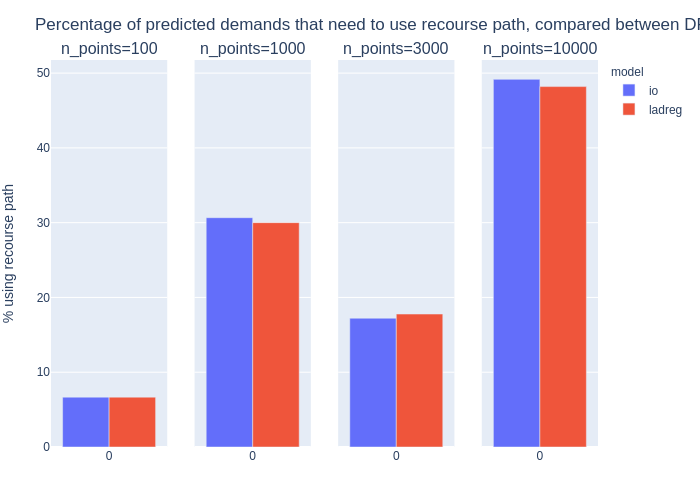

In [51]:
plot(
    recourse_analysis,
    kind="bar",
    y=:pct_recourse,
    text=:str_pct_recourse,
    facet_col=:n_points, 
    color=:model,
    Layout(
        xaxis_title="",
        yaxis_title="% using recourse path",
        title="Percentage of predicted demands that need to use recourse path, compared between DFL-IO and LAD Regression"
    )
)

We then look at the distribution of the flow over the recourse path for each model

In [52]:
all_recourses = @chain results begin
    subset(:recourse_flow => f -> f .> 0)
    subset(:dataset => d -> d .!= "wide")
end

first(all_recourses, 5)

5×7 DataFrame
 Row │ task_loss  recourse_flow  predicted_demand  actual_demand  dataset  mod ⋯
     │ Float64    Float64        Float64           Float64        Cat…     Cat ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 3.38824e8       0.338823           99.8127        100.339  close    io  ⋯
   2 │ 5.38694e9       5.38694            99.5675        105.387  close    io
   3 │ 3.38824e8       0.338823           99.8071        100.339  close    lad
   4 │ 5.38694e9       5.38694            99.5643        105.387  close    lad
   5 │ 5.46231e8       0.54623            99.7157        100.546  close    io  ⋯
                                                               2 columns omitted

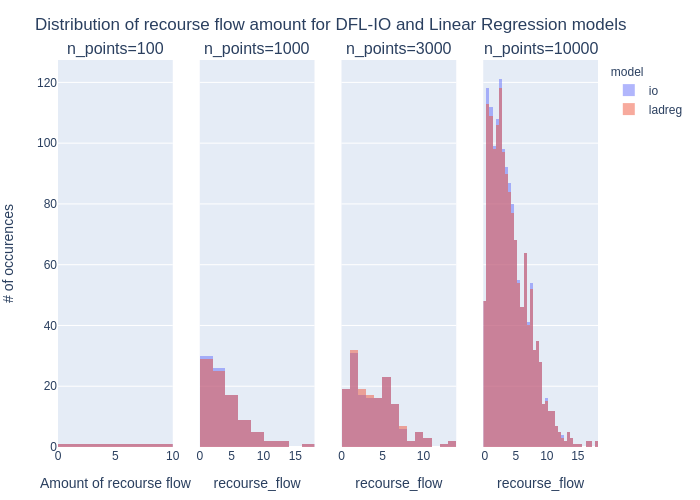

In [53]:
plot(
    all_recourses,
    kind="histogram",
    x=:recourse_flow,
    facet_col=:n_points, 
    color=:model,
    opacity=0.5,
    Layout(
        xaxis_title="Amount of recourse flow",
        yaxis_title="# of occurences",
        title="Distribution of recourse flow amount for DFL-IO and Linear Regression models",
        barmode="overlay"
    )
)

### Task losses

In [54]:
@chain results begin
    subset(:recourse_flow => r -> r .<= 0)
    groupby([:n_points, :dataset, :model])
    combine(:task_loss => (x -> [(mean(x), median(x), extrema(x)...)]) => [:mean, :median, :min, :max])
end

16×7 DataFrame
 Row │ n_points  dataset  model   mean      median    min       max      
     │ String    Cat…     Cat…    Float64   Float64   Float64   Float64  
─────┼───────────────────────────────────────────────────────────────────
   1 │ 100       close    io      1404.09   1247.93   970.859   2499.82
   2 │ 100       close    ladreg  1404.09   1247.93   970.859   2499.82
   3 │ 100       wide     io       220.645   212.758  145.379    338.275
   4 │ 100       wide     ladreg   220.645   212.758  145.379    338.275
   5 │ 1000      close    io      1138.31   1012.77   840.414   2508.3
   6 │ 1000      close    ladreg  1140.55   1040.02   840.414   2508.3
   7 │ 1000      wide     io       211.225   211.82    38.7262   354.796
   8 │ 1000      wide     ladreg   211.225   211.82    38.7262   354.796
   9 │ 3000      close    io      1229.2    1097.27   849.535   2869.02
  10 │ 3000      close    ladreg  1226.33   1095.89   849.535   2869.02
  11 │ 3000      wide     io       210.038   210.195   37.5248   362.693
  12 │ 3000      wide     ladreg   210.038   210.195   37.5248   362.693
  13 │ 10000     close    io       979.265   977.524  824.747   1820.46
  14 │ 10000     close    ladreg   989.569   979.097  824.747   2349.25
  15 │ 10000     wide     io       209.303   209.644   56.2138   379.937
  16 │ 10000     wide     ladreg   209.303   209.644   56.2138   379.937

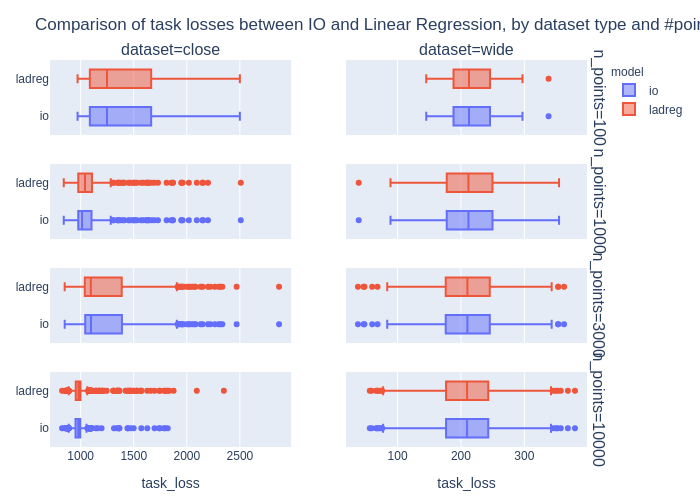

In [55]:
plot(
    subset(results, :recourse_flow => r -> r .<= 0),
    kind="box",
    x=:task_loss,
    facet_row=:n_points,
    facet_col=:dataset,
    color=:model,
    Layout(
        height=1000,
        title="Comparison of task losses between IO and Linear Regression, by dataset type and #points",
        #xaxis_title="task_loss"
    )
)

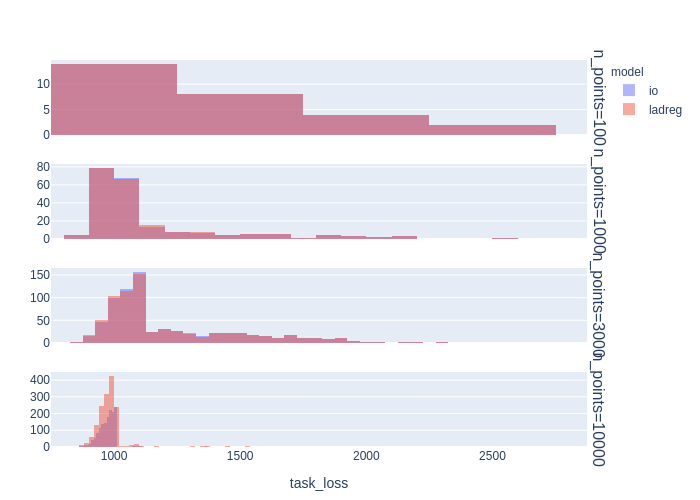

In [56]:
function plot_task_loss_distributions(results, dataset)
    no_recourse_results = @chain results begin
        subset(:recourse_flow => r -> r .<= 0)
        subset(:dataset => d -> d .== dataset)
    end
    
    return plot(
        no_recourse_results,
        kind="histogram",
        x=:task_loss,
        facet_row=:n_points, 
        color=:model,
        opacity=0.5,
        Layout(
            xaxis_title="",
            yaxis_title="",
            title="",
            barmode="overlay",
            height="1000",
            width="700"
        )
    )
end

plot_task_loss_distributions(results, "close")

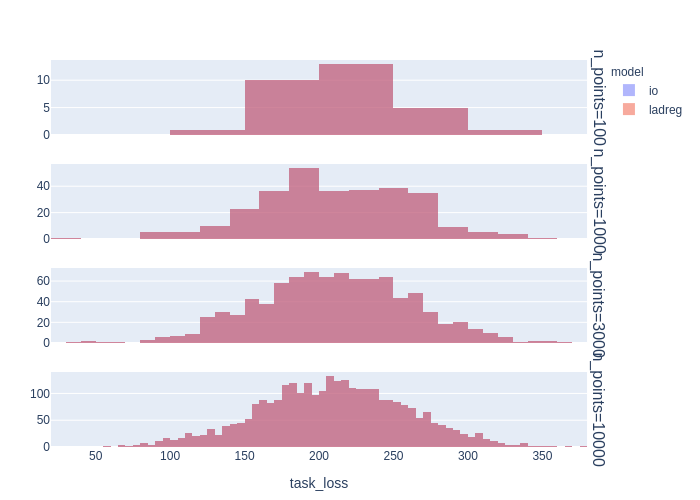

In [57]:
plot_task_loss_distributions(results, "wide")

### Comparison of predicted demands

In [67]:
pred_io = @chain results begin
    subset(:model => m -> m .== "io")
    @rename(:pred_io = :predicted_demand, :recourse_io = :recourse_flow)
    select(:dataset, :n_points, :pred_io, :recourse_io)
end 

pred_linreg = @chain results begin
    subset(:model => m -> m .== "ladreg")
    @rename(:pred_linreg = :predicted_demand, :recourse_linreg = :recourse_flow)
    select(:pred_linreg, :recourse_linreg)
end

pred_compared = hcat(pred_io, pred_linreg)

first(pred_compared, 5)

5×6 DataFrame
 Row │ dataset  n_points  pred_io   recourse_io  pred_linreg  recourse_linreg 
     │ Cat…     String    Float64   Float64      Float64      Float64         
─────┼────────────────────────────────────────────────────────────────────────
   1 │ close    100       102.065      0.0          102.038          0.0
   2 │ close    100       102.772      0.0          102.745          0.0
   3 │ close    100        99.8127     0.338823      99.8071         0.338823
   4 │ close    100       100.489      0.0          100.479          0.0
   5 │ close    100       100.364      0.0          100.361          0.0

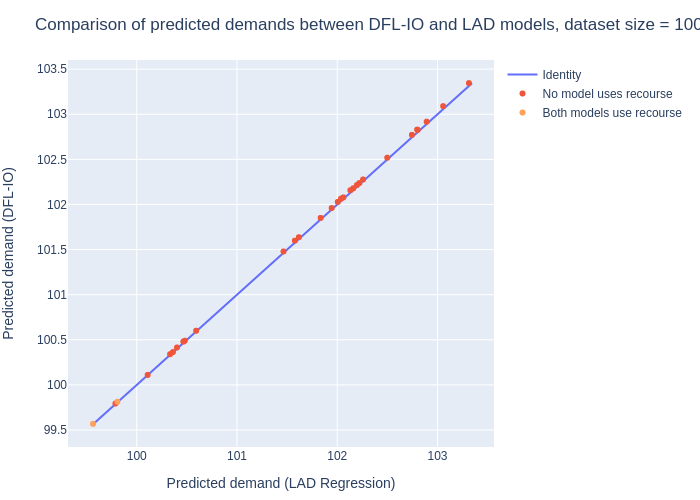

In [68]:
function categorise_compared_recourse(recourse_flow_io, recourse_flow_linreg)
    if recourse_flow_io .> 0 && recourse_flow_linreg .> 0
        return "both"
    elseif recourse_flow_io .> 0
        return "io"
    elseif recourse_flow_linreg > 0
        return "ladreg"
    end
    
    return "none"
end

function plot_prediction_comparison(pred_compared, n_points, dataset)
    filtered = @chain pred_compared begin
        @subset(:n_points .== "$n_points")
        @subset(:dataset .== dataset)
        @transform(@byrow :recourse_use = categorise_compared_recourse(:recourse_io, :recourse_linreg))
    end

    mn, mx = extrema(vcat(filtered.pred_io, filtered.pred_linreg))
    t = mn:0.01:mx

    return plot(
        [
            scatter(x=t, y=t, mode="lines", name="Identity"),
            scatter(filtered[filtered.recourse_use .== "none", :], x=:pred_linreg, y=:pred_io, mode="markers", name="No model uses recourse"),
            scatter(filtered[filtered.recourse_use .== "io", :], x=:pred_linreg, y=:pred_io, mode="markers", name="Only DFL-IO uses recourse"),
            scatter(filtered[filtered.recourse_use .== "ladreg", :], x=:pred_linreg, y=:pred_io, mode="markers", name="Only LinReg uses recourse"),
            scatter(filtered[filtered.recourse_use .== "both", :], x=:pred_linreg, y=:pred_io, mode="markers", name="Both models use recourse")
        ],
        Layout(
            xaxis_title="Predicted demand (LAD Regression)",
            yaxis_title="Predicted demand (DFL-IO)",
            title="Comparison of predicted demands between DFL-IO and LAD models, dataset size = $n_points"
        )
    )
end

plot_prediction_comparison(pred_compared, 100, "close")

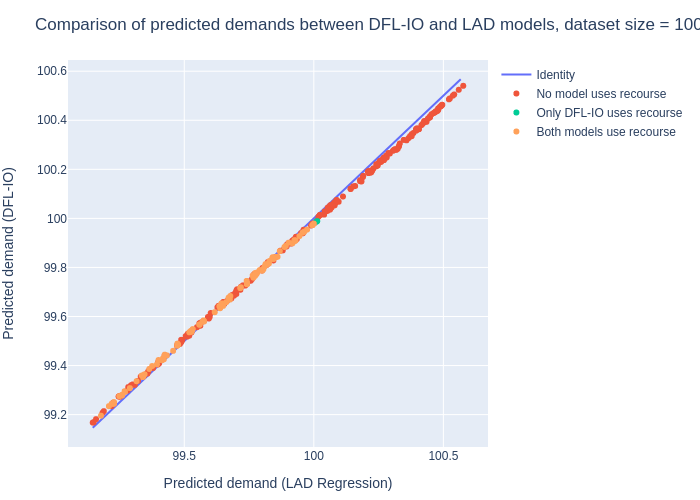

In [69]:
plot_prediction_comparison(pred_compared, 1000, "close")

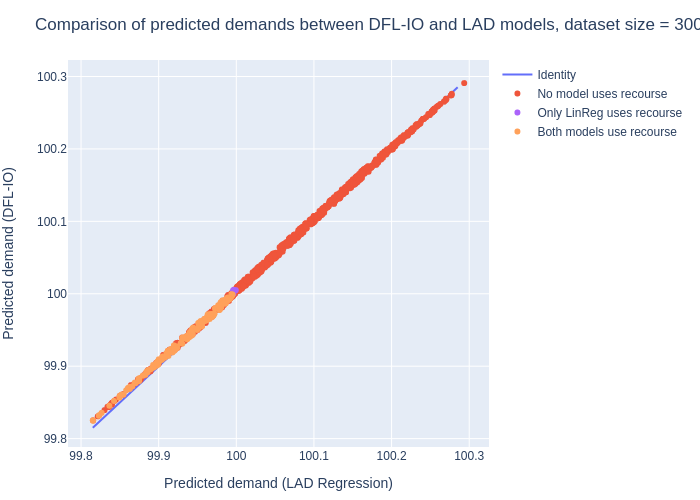

In [70]:
plot_prediction_comparison(pred_compared, 3000, "close")

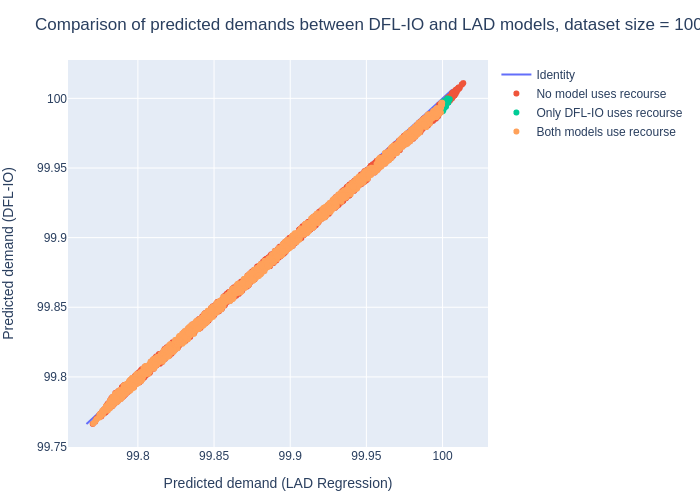

In [71]:
plot_prediction_comparison(pred_compared, 10000, "close")

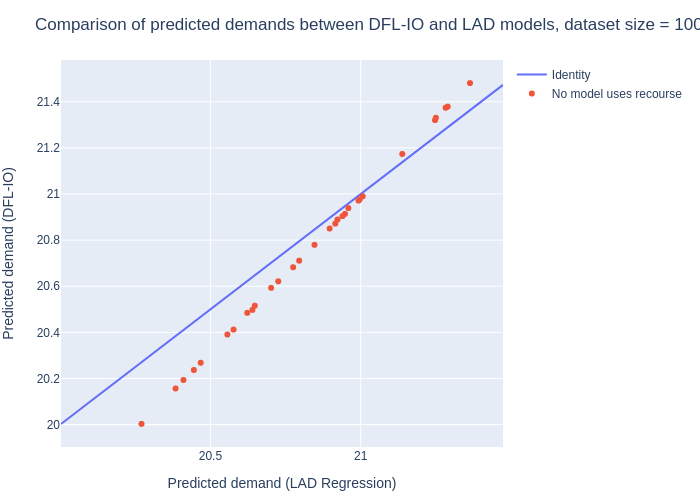

In [72]:
plot_prediction_comparison(pred_compared, 100, "wide")

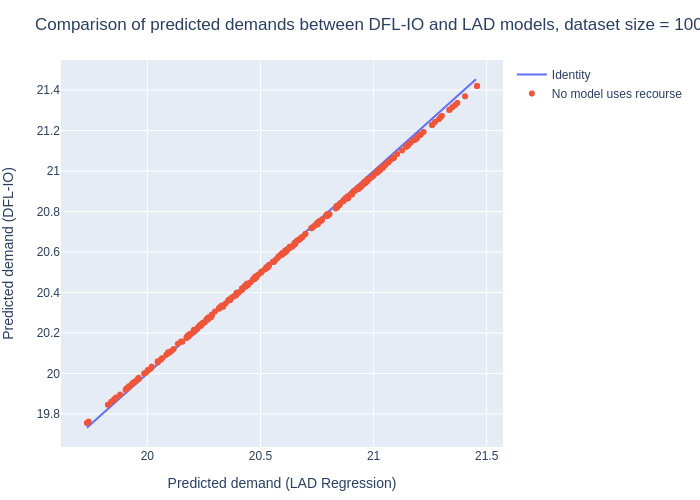

In [73]:
plot_prediction_comparison(pred_compared, 1000, "wide")

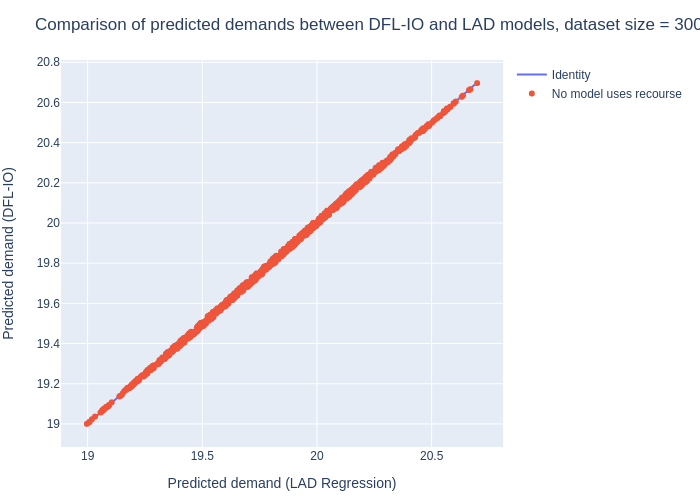

In [74]:
plot_prediction_comparison(pred_compared, 3000, "wide")

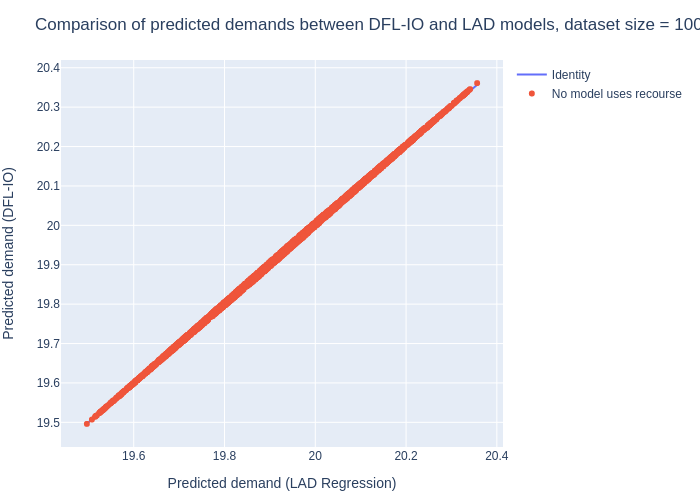

In [75]:
plot_prediction_comparison(pred_compared, 10000, "wide")